# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load CSV files
df_flights = pd.read_csv('Data/flightsV2.csv')

In [3]:
# Columns details
df_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance',
       'arr_delay'],
      dtype='object')

In [4]:
## Drop some columns we do not need
df_flights.drop(columns = ['branded_code_share', 'mkt_unique_carrier', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'op_carrier_fl_num', 'dup', 'flights'], inplace = True)

In [5]:
# Missing data detection
df_flights.isnull().sum()

fl_date                 0
tail_num              316
origin_airport_id       0
origin                  0
origin_city_name        0
dest_airport_id         0
dest                    0
dest_city_name          0
crs_dep_time            0
crs_arr_time            0
crs_elapsed_time        0
distance                0
arr_delay            1960
dtype: int64

In [6]:
## Only a small fraction of data is missing so we will just drop those rows instead of trying to impute
df_flights.dropna(inplace = True)

In [7]:
# Add Month and Day columns
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])

df_flights['month'] = df_flights['fl_date'].dt.month
df_flights['day'] = df_flights['fl_date'].dt.day

In [8]:
df_flights.head(3)

,fl_date,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,day
1,2019-04-30,N943SW,11413,DRO,"Durango, CO",11292,DEN,"Denver, CO",1130,1244,74,250,7.0,4,30
2,2018-12-25,N87337,11140,CRP,"Corpus Christi, TX",12266,IAH,"Houston, TX",535,637,62,201,-4.0,12,25
3,2018-11-28,N966AT,11433,DTW,"Detroit, MI",11996,GSP,"Greer, SC",2140,2335,115,508,-33.0,11,28


Let's Encode tail_num, origin airport and destination airport using average arrival delay for each of those airports

In [9]:
# Encode tail_num, origin airport and destination airport using mean arrival delay
df_tail = df_flights[['tail_num', 'arr_delay']]
df_origin = df_flights[['origin', 'arr_delay']]
df_dest = df_flights[['dest', 'arr_delay']]

In [10]:
df_tail = df_tail.groupby('tail_num', as_index = False).mean()
df_origin = df_origin.groupby('origin', as_index = False).mean()
df_dest = df_dest.groupby('dest', as_index = False).mean()

In [11]:
# Convert to dictionaries so we can use them to replace values 
dic_tail = df_tail.set_index('tail_num').to_dict()['arr_delay']
dic_origin = df_origin.set_index('origin').to_dict()['arr_delay']
dic_dest = df_dest.set_index('dest').to_dict()['arr_delay']

In [12]:
# Create dataframe with features we want to use for modelling
df_model = df_flights[['tail_num', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay', 'month', 'day']]
df_model['tail_num'].replace(dic_tail, inplace = True)
df_model['origin'].replace(dic_origin, inplace = True)
df_model['dest'].replace(dic_dest, inplace = True)

C:\Users\hgior\AppData\Local\Temp\ipykernel_32068\4126059928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['tail_num'].replace(dic_tail, inplace = True)
C:\Users\hgior\AppData\Local\Temp\ipykernel_32068\4126059928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['origin'].replace(dic_origin, inplace = True)
C:\Users\hgior\AppData\Local\Temp\ipykernel_32068\4126059928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [13]:
# Rename columns of the encoded features
df_model = df_model.rename(columns = {'tail_num':'avg_delay_tail_num', 'origin':'avg_delay_origin', 'dest':'avg_delay_dest'})

In [14]:
## Features to use for modelling
df_model

,avg_delay_tail_num,avg_delay_origin,avg_delay_dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,day
1,2.296296,2.854545,5.988561,1130,1244,74,250,7.0,4,30
2,20.875000,3.571429,5.687783,535,637,62,201,-4.0,12,25
3,-5.500000,5.122292,2.383673,2140,2335,115,508,-33.0,11,28
4,-3.954545,6.956799,10.413694,1929,2112,163,733,-13.0,5,6
5,5.250000,2.959515,1.326316,1008,1145,97,457,-15.0,11,14
...,...,...,...,...,...,...,...,...,...,...
99995,-3.952381,6.125364,7.095023,700,935,155,910,-13.0,8,11
99996,-0.608696,9.747001,9.022727,540,758,138,752,47.0,8,10
99997,-14.250000,10.153101,9.022727,1550,1900,130,812,-20.0,4,2
99998,-7.842105,6.280078,19.653990,1625,1829,124,529,-11.0,9,21


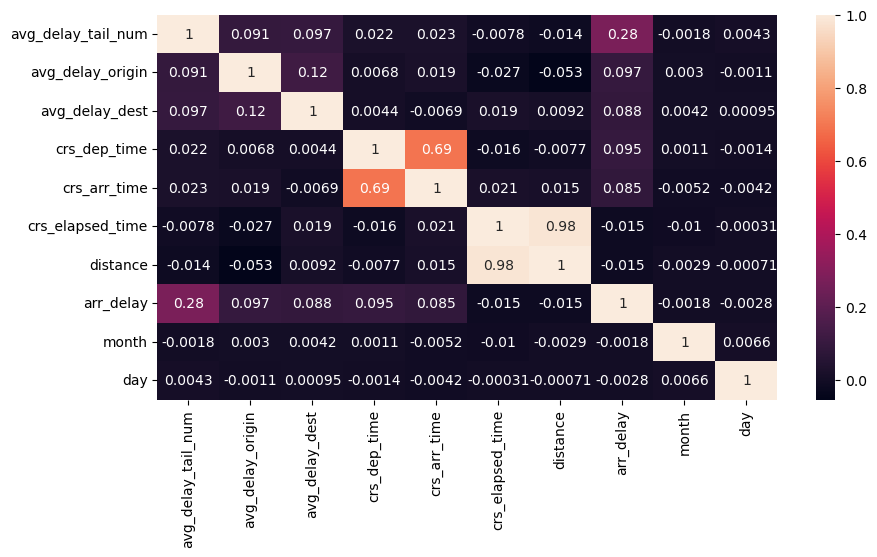

In [23]:
# Correlation matrix of features
corr=df_model.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True )
plt.show()

In [15]:
# Store model in CSV file
df_model.to_csv('featuresV1.csv', index = False)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

In [17]:
# Load model from CSV file
df_model = pd.read_csv('Data/featuresV1.csv')

In [18]:
# Define categorical and continuous features
cat_features = ['month']
cont_features = ['avg_delay_tail_num', 'avg_delay_origin', 'avg_delay_dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance']

##### Data configuration for Linear/Ridge/Lasso Regression

In [21]:
## Scale data 
df_model_scaled = df_model
scaler = StandardScaler()
df_model_scaled[cont_features] = scaler.fit_transform(df_model[cont_features])


In [22]:
# Split data into training and testing
X_scaled = df_model_scaled.drop(columns = ['arr_delay'])
y_scaled = df_model_scaled[['arr_delay']]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_scaled, y_scaled, train_size=0.8, test_size=0.2, random_state = 646)
print(f'{len(Xs_train)} training samples and {len(Xs_test)} test samples')

78432 training samples and 19608 test samples


In [25]:
# Create dummies features
df_ds = pd.get_dummies(df_model_scaled, columns=cat_features)

In [33]:
# Split dummies into training and testing
X_ds = df_ds.drop(columns = ['arr_delay'])
y_ds = df_ds[['arr_delay']]
Xds_train, Xds_test, yds_train, yds_test = train_test_split(X_ds, y_ds, train_size=0.8, test_size=0.2, random_state = 646)

##### Data configuration for XGB and Random Forest

In [34]:
df_model2 = df_model
## Drop days
df_model2.drop(columns = ['day'], inplace = True)

In [35]:
df_model2 = pd.get_dummies(df_model2, columns=cat_features)

In [36]:
X_dummys = df_model2.drop(columns = ['arr_delay'])
y_dummys = df_model2[['arr_delay']]

In [37]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_dummys, y_dummys, train_size=0.8, test_size=0.2, random_state = 646)

### Random Forest

In [34]:
## Hyperparameter tuning was run in a seperate notebook, code included here but commented out since GridSearch takes alot of time
# params_dict = {
#                 'n_estimators':[50,100],
#                 'max_depth' : [5,10,15],
#                 'max_features':[5,10,15],
#                 }

# rfr_search = GridSearchCV(estimator = model_rfr,
#                            param_grid = params_dict,                        
#                            n_jobs = -1,
#                            verbose = 1)
# rfr_search.fit(Xd_train,yd_train)

# rfr_search.best_params_

In [35]:
## instantiate model with optimal hyperparams from gridsearch
model_rfr = RandomForestRegressor(n_estimators=150, max_depth = 10, max_features = 10)

In [ ]:
model_rfr.fit(Xd_train,yd_train)
y_pred_train = model_rfr.predict(Xd_train)
y_pred_test = model_rfr.predict(Xd_test)

In [37]:
r2_train = r2_score(yd_train, y_pred_train)
r2_test = r2_score(yd_test, y_pred_test)
mae_train = mean_absolute_error(yd_train, y_pred_train)
mae_test = mean_absolute_error(yd_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.35228221772317836
The test r2 score is:  0.11992095108631906
The train MAE score is:  22.396306386501777
The test MAE score is:  23.608456305703836


### XGBoost

In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [39]:
## Hyperparameter tuning was run in a seperate notebook, code included here but commented out since GridSearch takes alot of time
# params_dict = {
#                 'learning_rate':[0.01,0.1],
#                 'colsample_bytree': [0.3,0.6,0.9],
#                 'n_estimators':[100,200,300],
#                 'max_depth':[10,15],
#                 'alpha':[5,10],
#                 'objective': ['reg:squarederror']}

# xgb_search = GridSearchCV(estimator = model_xgr,
#                            param_grid = params_dict,                        
#                            n_jobs = -1,
#                            verbose = 1)
# xgb_search.fit(Xd_train,yd_train)
# xgb_search.best_score_
# xgb_search.best_params_

In [40]:
## Fit with optimal  hyperparams from gridsearch
xgr = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 15, alpha = 10, n_estimators = 500)

In [41]:
model_xgr = xgr.fit(Xd_train,yd_train)
y_pred_train = model_xgr.predict(Xd_train)
y_pred_test = model_xgr.predict(Xd_test)

In [42]:
r2_train = r2_score(yd_train, y_pred_train)
r2_test = r2_score(yd_test, y_pred_test)
mae_train = mean_absolute_error(yd_train, y_pred_train)
mae_test = mean_absolute_error(yd_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.8514045256039005
The test r2 score is:  0.05006442891649365
The train MAE score is:  12.32838317523575
The test MAE score is:  24.149724961200345


### Linear/Lasso/Ridge Regression

In [43]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [44]:
model_lr = LinearRegression()
model_rr = Ridge()
model_ls = Lasso()

### Linear Regression

In [45]:
model_lr.fit(Xds_train,yds_train)
y_pred_train = model_lr.predict(Xds_train)
y_pred_test = model_lr.predict(Xds_test)

In [46]:
r2_train = r2_score(yds_train, y_pred_train)
r2_test = r2_score(yds_test, y_pred_test)
mae_train = mean_absolute_error(yds_train, y_pred_train)
mae_test = mean_absolute_error(yds_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.09202565992616996
The test r2 score is:  0.10912613251549608
The train MAE score is:  24.304918384311776
The test MAE score is:  24.110785129090882


### Lasso Regression

Try CV search for best param?

In [47]:
model_ls.fit(Xds_train,yds_train)
y_pred_train = model_ls.predict(Xds_train)
y_pred_test = model_ls.predict(Xds_test)

In [48]:
r2_train = r2_score(yds_train, y_pred_train)
r2_test = r2_score(yds_test, y_pred_test)
mae_train = mean_absolute_error(yds_train, y_pred_train)
mae_test = mean_absolute_error(yds_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.08774634294132277
The test r2 score is:  0.10247692452623025
The train MAE score is:  24.109581430384317
The test MAE score is:  23.924182949824694


### Ridge Regression

In [49]:
model_rr.fit(Xds_train,yds_train)
y_pred_train = model_rr.predict(Xds_train)
y_pred_test = model_rr.predict(Xds_test)

In [50]:
r2_train = r2_score(yds_train, y_pred_train)
r2_test = r2_score(yds_test, y_pred_test)
mae_train = mean_absolute_error(yds_train, y_pred_train)
mae_test = mean_absolute_error(yds_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.09202565971857646
The test r2 score is:  0.1091259194501305
The train MAE score is:  24.30488581599533
The test MAE score is:  24.11075395651564


### Regression with PCA

Text(0, 0.5, '% Cumulative explained variance')

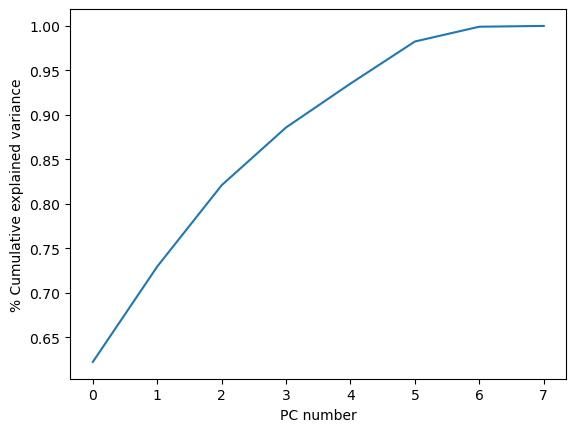

In [51]:
## First lets look at cumulative explained variance
pca = PCA()
pca.fit(df_model_scaled.drop(columns = ['arr_delay']))

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

## Plot cumulative explained variance against number of PCs
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

In [52]:
## Based on Cumulative explained variance, Choose 5 PCA components
pca = PCA(n_components=5)
df_pca = pd.DataFrame(pca.fit_transform(df_model_scaled.drop(columns = ['arr_delay'])))

In [53]:
## Split data
Xp_train, Xp_test, yp_train, yp_test = train_test_split(df_pca, y, train_size=0.8, test_size=0.2, random_state = 646)

In [54]:
## Linear Regression model
model_lr.fit(Xp_train,yp_train)
y_pred_train = model_lr.predict(Xp_train)
y_pred_test = model_lr.predict(Xp_test)

In [55]:
r2_train = r2_score(yp_train, y_pred_train)
r2_test = r2_score(yp_test, y_pred_test)
mae_train = mean_absolute_error(yp_train, y_pred_train)
mae_test = mean_absolute_error(yp_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.08859291882620801
The test r2 score is:  0.10398431007666065
The train MAE score is:  24.342352169691914
The test MAE score is:  24.156127470193905


In [56]:
## Lasso Regression model
model_ls.fit(Xp_train,yp_train)
y_pred_train = model_ls.predict(Xp_train)
y_pred_test = model_ls.predict(Xp_test)

r2_train = r2_score(yp_train, y_pred_train)
r2_test = r2_score(yp_test, y_pred_test)
mae_train = mean_absolute_error(yp_train, y_pred_train)
mae_test = mean_absolute_error(yp_test, y_pred_test)

print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.08742442421689611
The test r2 score is:  0.10241396060493368
The train MAE score is:  24.144806369278783
The test MAE score is:  23.95258529109294


In [57]:
## Ridge Regression model
model_rr.fit(Xp_train,yp_train)
y_pred_train = model_rr.predict(Xp_train)
y_pred_test = model_rr.predict(Xp_test)

r2_train = r2_score(yp_train, y_pred_train)
r2_test = r2_score(yp_test, y_pred_test)
mae_train = mean_absolute_error(yp_train, y_pred_train)
mae_test = mean_absolute_error(yp_test, y_pred_test)


print("The train r2 score is: ",  r2_train)
print("The test r2 score is: ",  r2_test)
print("The train MAE score is: ",  mae_train)
print("The test MAE score is: ",  mae_test)

The train r2 score is:  0.08859291881464282
The test r2 score is:  0.1039842339348015
The train MAE score is:  24.342328250277703
The test MAE score is:  24.15610417833535


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

The best model according to r2 score was the random forest model so we will use that for predicting the out of sample data

In [58]:
## Read Transformed test data
df_test = pd.read_csv('Data/test_transformed.csv')

In [59]:
df_test

,avg_delay_tail_num,avg_delay_origin,avg_delay_dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,8.964286,0.478873,9.053241,1810,1945,95,363,1,0,0,0,0,0,0,0,0,0,0,0
1,-3.600000,0.478873,9.053241,1150,1320,90,363,1,0,0,0,0,0,0,0,0,0,0,0
2,11.083333,0.478873,2.036205,2020,2130,70,333,1,0,0,0,0,0,0,0,0,0,0,0
3,6.312500,0.478873,2.036205,1340,1455,75,333,1,0,0,0,0,0,0,0,0,0,0,0
4,3.629630,0.478873,2.036205,915,1035,80,333,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148690,-12.333333,5.122292,8.019888,1755,1952,117,509,1,0,0,0,0,0,0,0,0,0,0,0
148691,4.523810,2.475962,9.861653,600,759,119,610,1,0,0,0,0,0,0,0,0,0,0,0
148692,-2.227273,2.959515,6.539683,1715,1816,121,589,1,0,0,0,0,0,0,0,0,0,0,0
148693,-2.227273,9.291925,1.926453,1851,2145,114,589,1,0,0,0,0,0,0,0,0,0,0,0


In [60]:
## Apply chosen model
y_pred = model_rfr.predict(df_test)

In [68]:
df_prediction = pd.read_csv('Data/submission_template.csv')

In [69]:
df_prediction['predicted_arr_delay'] = y_pred

In [70]:
df_prediction

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_arr_delay
0,2020-01-01,WN,5888,ONT,SFO,365.783787
1,2020-01-01,WN,6276,ONT,SFO,-14.779692
2,2020-01-01,WN,4598,ONT,SJC,320.729537
3,2020-01-01,WN,4761,ONT,SJC,218.816657
4,2020-01-01,WN,5162,ONT,SJC,173.406926
...,...,...,...,...,...,...
148690,2020-01-07,DL,4813,DTW,JFK,-11.243034
148691,2020-01-07,DL,4814,GSP,LGA,441.593641
148692,2020-01-07,DL,4815,ATL,XNA,-9.123394
148693,2020-01-07,DL,4815,XNA,ATL,-10.241243


In [71]:
## df_prediction.to_csv('predicted_delays.csv', index = False)